In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class CounterpartyAnalyzer:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = None
        self.load_data()
    
    def load_data(self):
        """Загрузка и предварительная обработка данных из Excel файла"""
        try:
            # Чтение Excel файла
            self.df = pd.read_excel(self.file_path, engine='openpyxl')
            print(f"Данные успешно загружены из Excel. Размер: {self.df.shape}")
            
            # Дополнительная обработка для Excel
            self._post_process_excel_data()
            
        except Exception as e:
            print(f"Ошибка загрузки Excel файла: {e}")
            # Попробуем использовать другой движок
            try:
                self.df = pd.read_excel(self.file_path, engine='xlrd')
                print(f"Данные загружены с помощью движка xlrd. Размер: {self.df.shape}")
                self._post_process_excel_data()
            except Exception as e2:
                print(f"Ошибка загрузки с xlrd: {e2}")
                # Создаем пустой DataFrame для продолжения работы
                self.df = pd.DataFrame()
                print("Создан пустой DataFrame для предотвращения ошибок")
    
    def _post_process_excel_data(self):
        """Пост-обработка данных после загрузки из Excel"""
        # Удаление полностью пустых строк и столбцов
        initial_shape = self.df.shape
        self.df = self.df.dropna(how='all')
        self.df = self.df.loc[:, ~self.df.columns.str.contains('^Unnamed')]
        
        print(f"Удалено пустых строк: {initial_shape[0] - self.df.shape[0]}")
        print(f"Финальный размер данных: {self.df.shape}")
        
        # Преобразование типов данных для часто используемых колонок
        self._convert_data_types()
    
    def _convert_data_types(self):
        """Преобразование типов данных для ключевых колонок"""
        # Словарь для преобразования типов (колонка: тип)
        type_conversions = {
            'Дата создания в КССС IBM': 'datetime64[ns]',
            'Дата регистрации': 'datetime64[ns]', 
            'Дата закрытия': 'datetime64[ns]',
            'Запись блокирована': 'bool',
            'Действующая запись': 'bool',
            'Плательщик НДС': 'bool'
        }
        
        for column, dtype in type_conversions.items():
            if column in self.df.columns:
                try:
                    if dtype == 'datetime64[ns]':
                        self.df[column] = pd.to_datetime(self.df[column], errors='coerce')
                    elif dtype == 'bool':
                        # Преобразование различных форматов boolean
                        self.df[column] = self.df[column].astype(str).str.lower().map({
                            'true': True, 'false': False, 'да': True, 'нет': False,
                            '1': True, '0': False
                        })
                except Exception as e:
                    print(f"Ошибка преобразования колонки {column}: {e}")
    
    def basic_info(self):
        """Базовая информация о данных"""
        print("=" * 50)
        print("БАЗОВАЯ ИНФОРМАЦИЯ О ДАННЫХ")
        print("=" * 50)
        
        print(f"Количество записей: {len(self.df)}")
        print(f"Количество колонок: {len(self.df.columns)}")
        print("\nСтруктура данных:")
        print(self.df.info())
        
        print("\nПервые 5 записей:")
        print(self.df.head())
        
        return self.df.describe(include='all')

    # Остальные методы класса остаются без изменений...
    def data_quality_analysis(self):
        """Анализ качества данных"""
        print("\n" + "=" * 50)
        print("АНАЛИЗ КАЧЕСТВА ДАННЫХ")
        print("=" * 50)
        
        # Анализ пропущенных значений
        missing_data = self.df.isnull().sum()
        missing_percent = (missing_data / len(self.df)) * 100
        
        quality_report = pd.DataFrame({
            'Колонка': self.df.columns,
            'Тип данных': self.df.dtypes.values,
            'Пропущенные значения': missing_data.values,
            'Процент пропусков': missing_percent.values,
            'Уникальные значения': [self.df[col].nunique() for col in self.df.columns]
        })
        
        print("Отчет о качестве данных:")
        print(quality_report.sort_values('Процент пропусков', ascending=False).head(20))
        
        # Визуализация пропущенных значений
        plt.figure(figsize=(15, 8))
        missing_plot_data = missing_percent[missing_percent > 0].sort_values(ascending=False)
        plt.bar(missing_plot_data.index[:20], missing_plot_data.values[:20])
        plt.xticks(rotation=90)
        plt.title('Топ-20 колонок с наибольшим процентом пропусков')
        plt.ylabel('Процент пропусков (%)')
        plt.tight_layout()
        plt.show()
        
        return quality_report

    def organizational_analysis(self):
        """Анализ организационно-правовых форм"""
        print("\n" + "=" * 50)
        print("АНАЛИЗ ОРГАНИЗАЦИОННО-ПРАВОВЫХ ФОРМ")
        print("=" * 50)
        
        # Анализ типов контрагентов
        if 'Организационно-правовая форма (обращение)' in self.df.columns:
            org_forms = self.df['Организационно-правовая форма (обращение)'].value_counts()
            print("Распределение по организационно-правовым формам:")
            print(org_forms)
            
            # Визуализация
            plt.figure(figsize=(12, 6))
            org_forms.head(10).plot(kind='bar')
            plt.title('Топ-10 организационно-правовых форм')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        
        # Анализ групп контрагентов
        if 'Группа контрагентов' in self.df.columns:
            group_counts = self.df['Группа контрагентов'].value_counts()
            print("\nРаспределение по группам контрагентов:")
            print(group_counts)
            
            plt.figure(figsize=(10, 6))
            group_counts.plot(kind='pie', autopct='%1.1f%%')
            plt.title('Распределение по группам контрагентов')
            plt.show()

    def geographical_analysis(self):
        """Географический анализ"""
        print("\n" + "=" * 50)
        print("ГЕОГРАФИЧЕСКИЙ АНАЛИЗ")
        print("=" * 50)
        
        geo_columns = [col for col in self.df.columns if any(geo in col for geo in ['Страна', 'Регион', 'Город', 'Индекс'])]
        print(f"Географические колонки: {geo_columns}")
        
        # Анализ по регионам
        if 'Регион (ЮА)' in self.df.columns:
            regions = self.df['Регион (ЮА)'].value_counts()
            print("\nТоп-10 регионов:")
            print(regions.head(10))
            
            plt.figure(figsize=(12, 6))
            regions.head(10).plot(kind='bar')
            plt.title('Топ-10 регионов по количеству контрагентов')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        
        # Анализ по городам
        if 'Город (ЮА)/ru_RU' in self.df.columns:
            cities = self.df['Город (ЮА)/ru_RU'].value_counts()
            print("\nТоп-10 городов:")
            print(cities.head(10))

    def temporal_analysis(self):
        """Анализ временных меток"""
        print("\n" + "=" * 50)
        print("ВРЕМЕННОЙ АНАЛИЗ")
        print("=" * 50)
        
        date_columns = [col for col in self.df.columns if 'Дата' in col]
        print(f"Колонки с датами: {date_columns}")
        
        # Анализ даты создания
        if 'Дата создания в КССС IBM' in self.df.columns:
            creation_dates = pd.to_datetime(self.df['Дата создания в КССС IBM'], errors='coerce')
            
            # Годовое распределение
            yearly_counts = creation_dates.dt.year.value_counts().sort_index()
            
            plt.figure(figsize=(12, 6))
            yearly_counts.plot(kind='bar')
            plt.title('Количество созданных контрагентов по годам')
            plt.xlabel('Год')
            plt.ylabel('Количество')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

    def tax_analysis(self):
        """Анализ налоговых данных"""
        print("\n" + "=" * 50)
        print("АНАЛИЗ НАЛОГОВЫХ ДАННЫХ")
        print("=" * 50)
        
        # Анализ ИНН
        if 'ИНН' in self.df.columns:
            inn_data = self.df['ИНН']
            print(f"Количество уникальных ИНН: {inn_data.nunique()}")
            print(f"Количество дубликатов ИНН: {len(inn_data) - inn_data.nunique()}")
            
            # Проверка формата ИНН (10 или 12 цифр)
            def validate_inn(inn):
                if pd.isna(inn) or inn == '-':
                    return 'Не указан'
                inn_str = str(inn)
                if inn_str.isdigit():
                    if len(inn_str) == 10:
                        return 'Юридическое лицо (10 цифр)'
                    elif len(inn_str) == 12:
                        return 'Физическое лицо (12 цифр)'
                return 'Некорректный формат'
            
            inn_types = self.df['ИНН'].apply(validate_inn).value_counts()
            print("\nТипы ИНН:")
            print(inn_types)

    def status_analysis(self):
        """Анализ статусов контрагентов"""
        print("\n" + "=" * 50)
        print("АНАЛИЗ СТАТУСОВ КОНТРАГЕНТОВ")
        print("=" * 50)
        
        # Анализ блокировок
        if 'Запись блокирована' in self.df.columns:
            blocked_status = self.df['Запись блокирована'].value_counts()
            print("Статус блокировки:")
            print(blocked_status)
        
        # Анализ действующих записей
        if 'Действующая запись' in self.df.columns:
            active_status = self.df['Действующая запись'].value_counts()
            print("\nСтатус активности:")
            print(active_status)

    def comprehensive_report(self):
        """Комплексный отчет"""
        print("=" * 80)
        print("КОМПЛЕКСНЫЙ АНАЛИТИЧЕСКИЙ ОТЧЕТ")
        print("=" * 80)
        
        # Сбор всех анализов
        self.basic_info()
        quality_report = self.data_quality_analysis()
        self.organizational_analysis()
        self.geographical_analysis()
        self.temporal_analysis()
        self.tax_analysis()
        self.status_analysis()
        
        # Сводная статистика
        print("\n" + "=" * 50)
        print("СВОДНАЯ СТАТИСТИКА")
        print("=" * 50)
        
        summary = {
            'Общее количество записей': len(self.df),
            'Количество колонок': len(self.df.columns),
            'Колонки с >50% пропусков': len(quality_report[quality_report['Процент пропусков'] > 50]),
            'Колонки без пропусков': len(quality_report[quality_report['Процент пропусков'] == 0]),
        }
        
        for key, value in summary.items():
            print(f"{key}: {value}")
        
        return summary


Данные успешно загружены из Excel. Размер: (674409, 160)
Удалено пустых строк: 0
Финальный размер данных: (674409, 160)
КОМПЛЕКСНЫЙ АНАЛИТИЧЕСКИЙ ОТЧЕТ
БАЗОВАЯ ИНФОРМАЦИЯ О ДАННЫХ
Количество записей: 674409
Количество колонок: 160

Структура данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674409 entries, 0 to 674408
Columns: 160 entries, Код КССС to Код ИСП
dtypes: bool(34), datetime64[ns](3), float64(29), int64(6), object(88)
memory usage: 670.2+ MB
None

Первые 5 записей:
   Код КССС  Запись блокирована Автор задания  Синхронизирован с ЕГРЮЛ  \
0     39465               False           NaN                    False   
1   2604498               False           NaN                    False   
2   3440257               False           NaN                    False   
3     53537               False           NaN                    False   
4     39466               False           NaN                    False   

  Дата синхронизации с ЕГРЮЛ  Исключение ЕГРЮЛ Действующая запись 

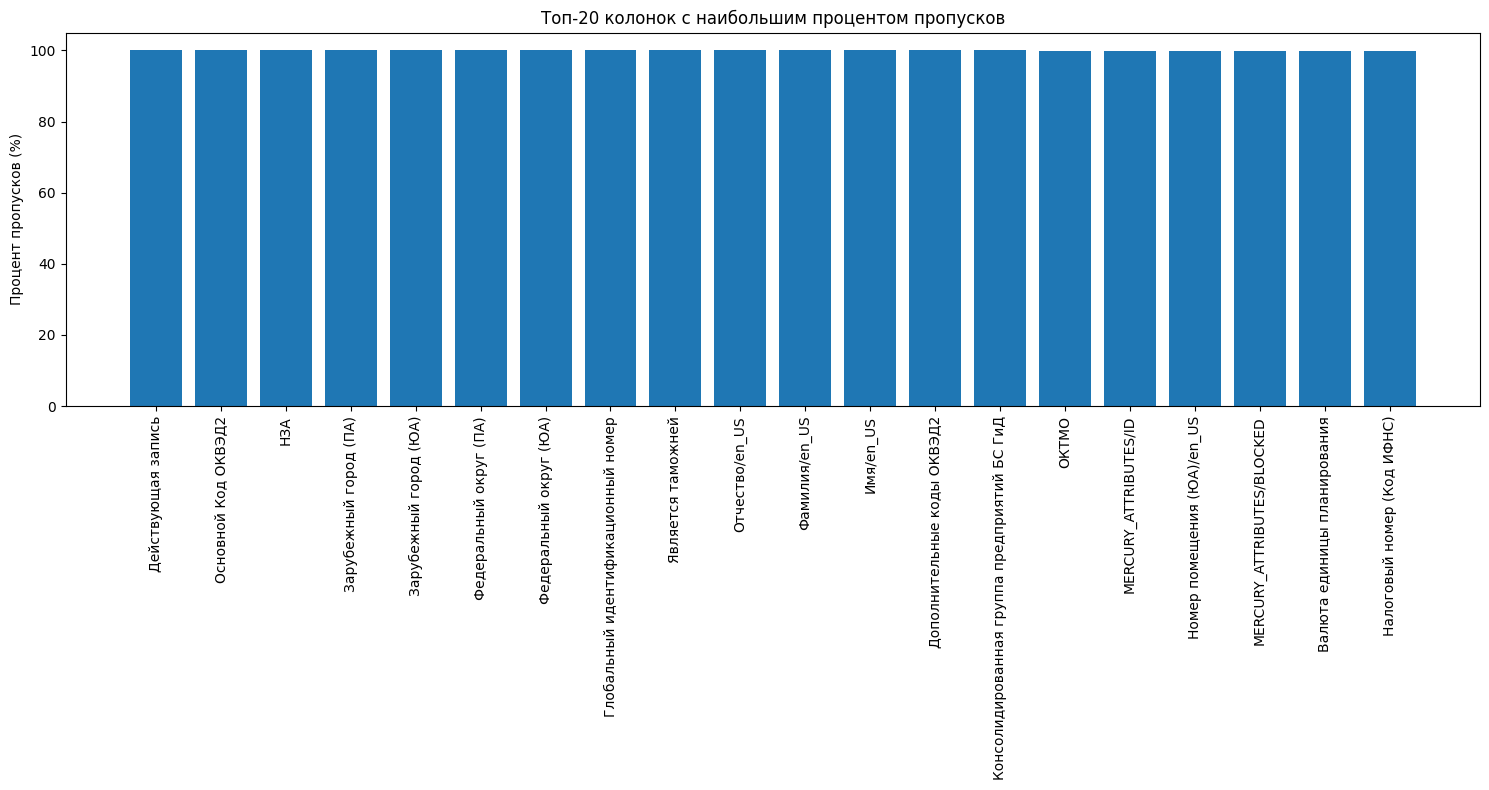


АНАЛИЗ ОРГАНИЗАЦИОННО-ПРАВОВЫХ ФОРМ
Распределение по организационно-правовым формам:
Организационно-правовая форма (обращение)
4.0      353303
82.0     191950
23.0      72968
22.0      15450
2.0        9146
          ...  
90.0          1
95.0          1
25.0          1
94.0          1
438.0         1
Name: count, Length: 201, dtype: int64


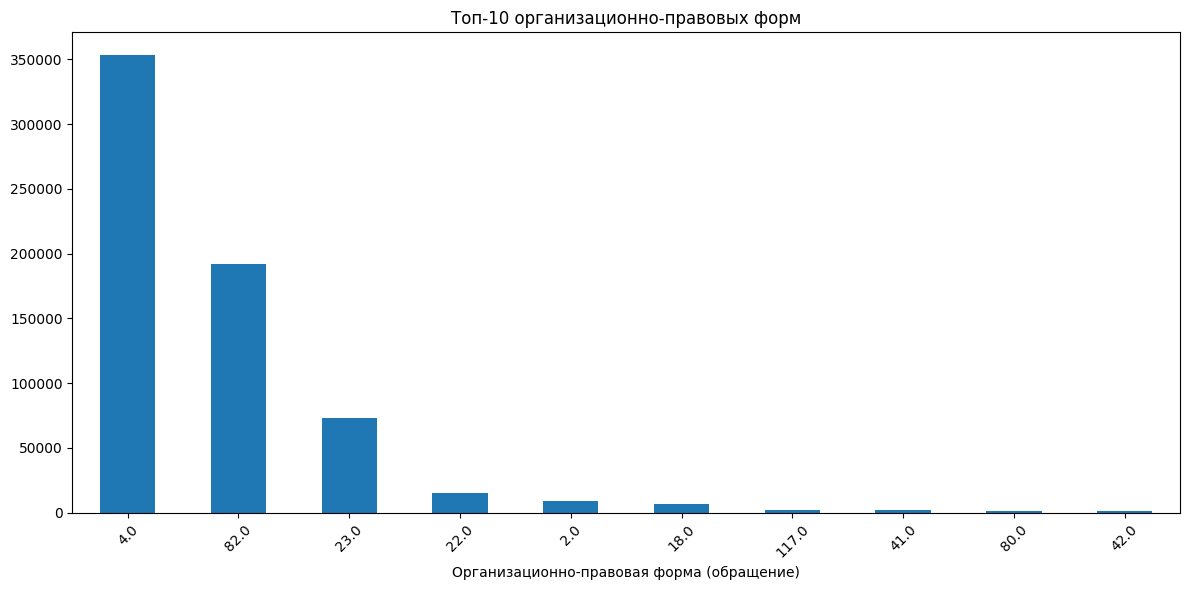


Распределение по группам контрагентов:
Группа контрагентов
1.0    75765
6.0    16578
2.0     9474
3.0     9272
4.0     1089
8.0      991
7.0      247
Name: count, dtype: int64


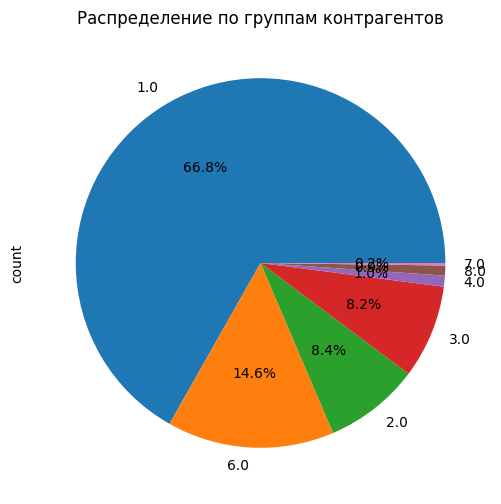


ГЕОГРАФИЧЕСКИЙ АНАЛИЗ
Географические колонки: ['Индекс (ЮА)', 'Страна (ЮА)', 'Страна (ЮА).1', 'Регион (ЮА)', 'Регион (ЮА).1', 'Город (ЮА)/ru_RU', 'Город (ЮА)/en_US', 'Индекс (ПА)', 'Страна (ПА)', 'Страна (ПА).1', 'Регион (ПА)', 'Регион (ПА).1', 'Город (ПА)/ru_RU', 'Город (ПА)/en_US']

Топ-10 регионов:
Регион (ЮА)
1418.0    87877
1832.0    39831
1417.0    38765
1374.0    34617
1408.0    30108
1390.0    27204
1391.0    24202
1340.0    21523
1397.0    21331
1412.0    20866
Name: count, dtype: int64


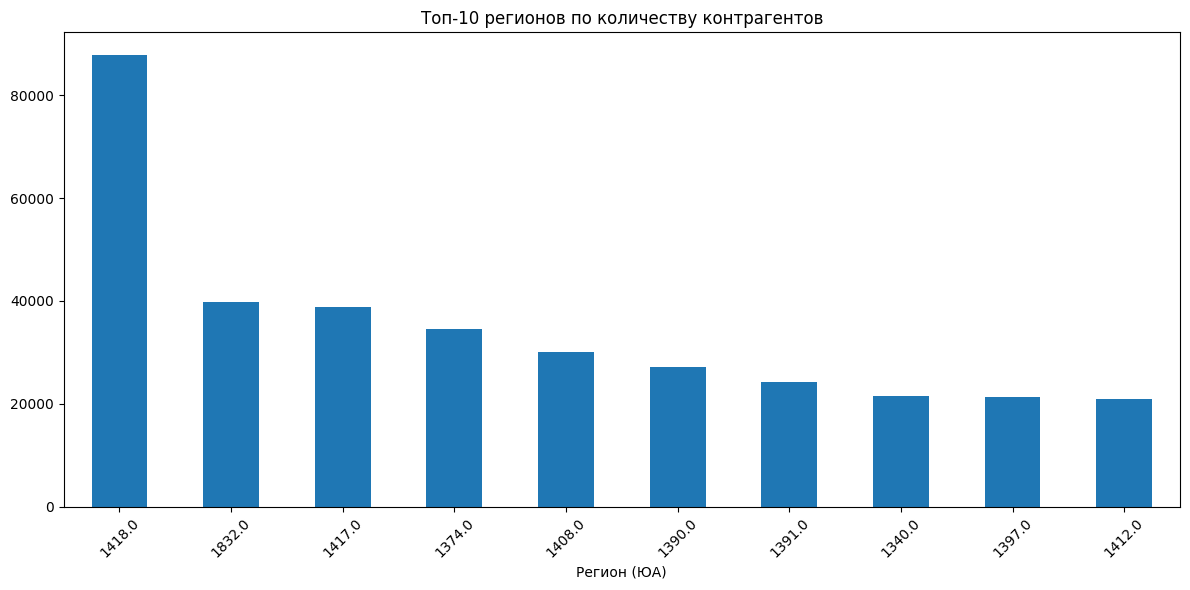


Топ-10 городов:
Город (ЮА)/ru_RU
-                        55914
г. Москва                41431
ГОРОД МОСКВА             28851
ГОРОД САНКТ-ПЕТЕРБУРГ    15994
г. Санкт-Петербург       15649
г. Пермь                  8213
Москва                    6858
ГОРОД ЕКАТЕРИНБУРГ        6837
г. Волгоград              6172
ГОРОД ПЕРМЬ               5951
Name: count, dtype: int64

ВРЕМЕННОЙ АНАЛИЗ
Колонки с датами: ['Дата синхронизации с ЕГРЮЛ', 'Дата регистрации', 'Дата закрытия', 'Дата начала действия КПП для крупнейшего налогоплательщика', 'Дата присвоения ОГРН', 'Дата создания в КССС IBM']


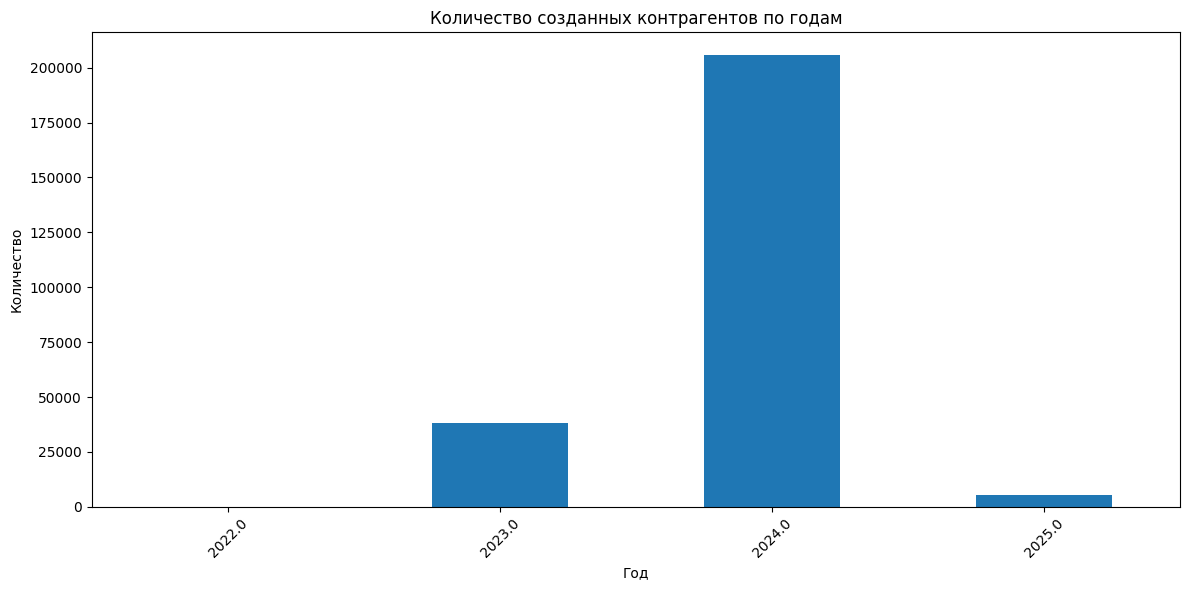


АНАЛИЗ НАЛОГОВЫХ ДАННЫХ
Количество уникальных ИНН: 537642
Количество дубликатов ИНН: 136767

Типы ИНН:
ИНН
Юридическое лицо (10 цифр)    470574
Не указан                     103432
Физическое лицо (12 цифр)     100402
Некорректный формат                1
Name: count, dtype: int64

АНАЛИЗ СТАТУСОВ КОНТРАГЕНТОВ
Статус блокировки:
Запись блокирована
False    673461
True        948
Name: count, dtype: int64

Статус активности:
Series([], Name: count, dtype: int64)

СВОДНАЯ СТАТИСТИКА
Общее количество записей: 674409
Количество колонок: 160
Колонки с >50% пропусков: 88
Колонки без пропусков: 43

ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ
Числовые колонки: ['Код КССС', 'Причина реорганизации', 'Группа контрагентов', 'Организационно-правовая форма (обращение)', 'КПП для крупнейшего налогоплательщика', 'Код ОГРН', 'Основной Код ОКВЭД2', 'НЗА', 'Глобальный идентификационный номер', 'ОКТМО', 'Собственная балансовая единица', 'Принадлежность к дочерним / зависимым предприятиям ПАО ЛУКОЙЛ', 'Принадлежность к дочерним

In [6]:
# Использование анализатора

    # Укажите путь к вашему Excel файлу
excel_file_path = 'KONTRAGENTY.xlsx'  # Замените на актуальный путь
    
analyzer = CounterpartyAnalyzer(excel_file_path)
    
    # Запуск комплексного анализа
summary = analyzer.comprehensive_report()
    
    # Дополнительный анализ
print("\n" + "=" * 80)
print("ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ")
print("=" * 80)
    
    # Анализ числовых колонок
numeric_cols = analyzer.df.select_dtypes(include=[np.number]).columns
print(f"Числовые колонки: {list(numeric_cols)}")
    
    # Сохранение отчета
    #try:
    #    analyzer.df.to_excel('analyzed_counterparties.xlsx', index=False)
    #    print("\nРезультаты анализа сохранены в 'analyzed_counterparties.xlsx'")
    #except Exception as e:
    #    print(f"Ошибка сохранения: {e}")




In [8]:
df = analyzer.df

In [9]:
df.head()

,Код КССС,Запись блокирована,Автор задания,Синхронизирован с ЕГРЮЛ,Дата синхронизации с ЕГРЮЛ,Исключение ЕГРЮЛ,Действующая запись,Дата регистрации,Дата закрытия,Причина реорганизации,...,Категория для ЗРСО,Консолидированная группа предприятий БС ГиД,Является головной организацией БЕ,Является головной организацией ЕП (текущее значение),Валюта единицы планирования,Метод бюджетирования (текущее значение),Участвует в КИК (текущее значение),Валюта (текущее значение),Комплект документов для участия в договорном процессе,Код ИСП
0,39465,False,NaN,False,NaN,False,NaN,NaT,NaT,NaN,...,NaN,NaN,False,False,NaN,NaN,False,NaN,False,NaN
1,2604498,False,NaN,False,NaN,False,NaN,NaT,NaT,NaN,...,NaN,NaN,False,False,NaN,NaN,False,NaN,False,NaN
2,3440257,False,NaN,False,NaN,False,NaN,NaT,NaT,NaN,...,NaN,NaN,False,False,NaN,NaN,False,NaN,False,NaN
3,53537,False,NaN,False,NaN,False,NaN,NaT,NaT,NaN,...,NaN,NaN,False,False,NaN,NaN,False,NaN,False,NaN
4,39466,False,NaN,False,NaN,False,NaN,NaT,NaT,NaN,...,NaN,NaN,False,False,NaN,NaN,False,NaN,False,NaN


In [12]:
def advanced_analysis(analyzer):
    """Расширенный анализ данных"""
    
    # Анализ связей между полями
    df = analyzer.df
    
    # Создание сводной таблицы по регионам и типам организаций
    if 'Регион (ЮА)' in df.columns and 'Организационно-правовая форма (обращение)' in df.columns:
        pivot_table = pd.crosstab(
            df['Регион (ЮА)'], 
            df['Организационно-правовая форма (обращение)'],
            margins=True
        )
        print("Сводная таблица: Регионы vs Организационные формы")
        print(pivot_table)
    
    # Анализ временных трендов
    date_cols = [col for col in df.columns if 'Дата' in col]
    for date_col in date_cols[:3]:  # Анализ первых 3 дат
        if date_col in df.columns:
            dates = pd.to_datetime(df[date_col], errors='coerce')
            if not dates.isna().all():
                print(f"\nАнализ {date_col}:")
                print(f"  Первая дата: {dates.min()}")
                print(f"  Последняя дата: {dates.max()}")
                print(f"  Период охвата: {dates.max() - dates.min()}")

# Запуск расширенного анализа
advanced_analysis(analyzer)


Сводная таблица: Регионы vs Организационные формы
Организационно-правовая форма (обращение)   2.0     4.0  5.0  6.0  7.0  8.0  \
Регион (ЮА)                                                                   
1.0                                           0       0    0    0    0    0   
2.0                                           0       0    0    0    0    0   
3.0                                           0       0    0    0    0    0   
4.0                                           0       0    0    0    0    0   
5.0                                           0       0    0    0    0    0   
...                                         ...     ...  ...  ...  ...  ...   
4572.0                                        0       0    0    0    0    0   
4573.0                                        0       0    0    0    0    0   
4575.0                                        0       0    0    0    0    0   
4582.0                                        0       0    0    0    0    0   
Al

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os

def clean_sheet_name(name):
    """Очищает имя листа от недопустимых символов"""
    # Недопустимые символы в Excel: / \ * ? [ ] :
    invalid_chars = ['/', '\\', '*', '?', '[', ']', ':']
    clean_name = str(name)
    for char in invalid_chars:
        clean_name = clean_name.replace(char, '_')
    
    # Ограничение длины имени листа (31 символ)
    clean_name = clean_name[:31]
    
    # Убедимся, что имя не пустое
    if not clean_name.strip():
        clean_name = "Лист_1"
    
    return clean_name

def rename_reorganization_reasons(df):
    """
    Переименовывает значения в поле 'Причина реорганизации'
    Пока заменяет значения сами на себя (заглушка для будущих преобразований)
    """
    if 'Причина реорганизации' in df.columns:
        # Создаем копию для безопасности
        df = df.copy()
        
        # Заменяем пустые значения на стандартное обозначение
        df['Причина реорганизации'] = df['Причина реорганизации'].fillna('Не указана')
        
        # Тут можно добавить логику переименования значений
        # Например:
        reason_mapping = {
             1: 'Слияние',
             2: 'Присоединения',
             3: 'Разделение',
             4: 'Выделение',
             5: 'Преобразование',
             6: 'Ликвидация',
             7: 'Дублирование'
         }
        df['Причина реорганизации'] = df['Причина реорганизации'].map(reason_mapping).fillna(df['Причина реорганизации'])
        
        print("✅ Значения поля 'Причина реорганизации' обработаны")
    
    return df

def analyze_closed_records(df, results_folder):
    """
    Анализ записей с датой закрытия
    """
    print("\n" + "=" * 80)
    print("АНАЛИЗ ЗАКРЫТЫХ ЗАПИСЕЙ")
    print("=" * 80)
    
    if 'Дата закрытия' not in df.columns:
        print("❌ Поле 'Дата закрытия' не найдено в данных")
        return
    
    # Записи с датой закрытия
    closed_records = df[df['Дата закрытия'].notna()]
    
    print(f"Всего записей с датой закрытия: {len(closed_records)}")
    print(f"Процент от общего количества: {len(closed_records)/len(df)*100:.1f}%")
    
    if len(closed_records) > 0:
        # Анализ по причинам реорганизации
        if 'Причина реорганизации' in closed_records.columns:
            reason_analysis = closed_records['Причина реорганизации'].value_counts()
            print("\nРаспределение по причинам реорганизации:")
            for reason, count in reason_analysis.items():
                percentage = count / len(closed_records) * 100
                print(f"  {reason}: {count} ({percentage:.1f}%)")
        
        # Анализ по годам закрытия
        closed_records['Дата закрытия'] = pd.to_datetime(closed_records['Дата закрытия'], errors='coerce')
        closed_records = closed_records[closed_records['Дата закрытия'].notna()]
        
        if len(closed_records) > 0:
            closed_records['Год_закрытия'] = closed_records['Дата закрытия'].dt.year
            yearly_closures = closed_records['Год_закрытия'].value_counts().sort_index()
            
            #print("\nЗакрытия по годам:")
            #for year, count in yearly_closures.items():
                #print(f"  {year}: {count} записей")
            
            # Визуализация
            plt.figure(figsize=(12, 6))
            yearly_closures.plot(kind='bar', color='lightcoral')
            plt.title('Количество закрытых записей по годам')
            plt.xlabel('Год')
            plt.ylabel('Количество записей')
            plt.xticks(rotation=45)
            plt.tight_layout()
            
            plot_path = os.path.join(results_folder, "закрытые_записи_по_годам.png")
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            plt.show()
            print(f"  📈 График сохранен: {plot_path}")
        
        # Сохраняем анализ закрытых записей в Excel
        save_closed_records_analysis(closed_records, results_folder)

def save_closed_records_analysis(closed_records, results_folder):
    """Сохраняет анализ закрытых записей в Excel"""
    print("\n💾 Сохранение анализа закрытых записей...")
    
    output_path = os.path.join(results_folder, "анализ_закрытых_записей.xlsx")
    
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        # Основные данные
        columns_to_save = closed_records.columns[:80].tolist()
        closed_limited = closed_records[columns_to_save]
        closed_limited.to_excel(writer, sheet_name='Закрытые_записи', index=False)
        
        # Анализ по причинам
        if 'Причина реорганизации' in closed_records.columns:
            reason_stats = closed_records['Причина реорганизации'].value_counts().reset_index()
            reason_stats.columns = ['Причина_реорганизации', 'Количество']
            reason_stats['Процент'] = (reason_stats['Количество'] / len(closed_records) * 100).round(2)
            reason_stats.to_excel(writer, sheet_name='Статистика_по_причинам', index=False)
        
        # Анализ по годам
        if 'Год_закрытия' in closed_records.columns:
            year_stats = closed_records['Год_закрытия'].value_counts().sort_index().reset_index()
            year_stats.columns = ['Год_закрытия', 'Количество']
            year_stats.to_excel(writer, sheet_name='Статистика_по_годам', index=False)
    
    print(f"  📊 Анализ закрытых записей сохранен в: {output_path}")

def analyze_inn_duplicates(df):
    """
    Анализ дубликатов ИНН с учетом различных условий и фильтров
    """
    print("=" * 80)
    print("АНАЛИЗ ДУБЛИКАТОВ ИНН")
    print("=" * 80)
    
    # Создаем папку для результатов
    results_folder = "inn_analysis_results"
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
    
    # Создаем копию данных для анализа
    analysis_df = df.copy()
    
    # Обрабатываем причины реорганизации
    analysis_df = rename_reorganization_reasons(analysis_df)
    
    # Предварительная обработка данных
    analysis_df = preprocess_data(analysis_df)
    
    # Анализ закрытых записей (отдельно)
    analyze_closed_records(analysis_df, results_folder)
    
    # Исключаем закрытые записи из анализа дубликатов
    analysis_df = exclude_closed_records(analysis_df)
    
    # Базовая статистика по ИНН
    basic_inn_statistics(analysis_df)
    
    # Анализ дубликатов ИНН
    analyze_inn_duplicates_detailed(analysis_df, results_folder)
    
    # Анализ дубликатов в разрезе ключевых полей
    analyze_duplicates_by_fields(analysis_df, results_folder)
    
    # Визуализация результатов
    visualize_inn_analysis(analysis_df, results_folder)
    
    print(f"\n📁 Результаты сохранены в папку: {results_folder}")

def exclude_closed_records(df):
    """Исключает записи с датой закрытия из анализа"""
    if 'Дата закрытия' in df.columns:
        initial_count = len(df)
        # Исключаем записи с датой закрытия
        df = df[df['Дата закрытия'].isna()]
        closed_count = initial_count - len(df)
        print(f"Исключено записей с датой закрытия: {closed_count}")
        print(f"Осталось записей для анализа дубликатов: {len(df)}")
    return df

def preprocess_data(df):
    """Предварительная обработка данных"""
    print("\n1. ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ")
    print("-" * 40)
    
    # Обработка поля ИНН
    if 'ИНН' not in df.columns:
        print("❌ ОШИБКА: Поле 'ИНН' не найдено в данных")
        return df
    
    # Замена различных обозначений пустых значений
    df['ИНН'] = df['ИНН'].replace(['-', '—', '–', ' ', ''], np.nan)
    
    # Преобразование в строку и удаление пробелов
    df['ИНН'] = df['ИНН'].astype(str).str.strip()
    
    # Замена 'nan' строк на настоящие NaN
    df['ИНН'] = df['ИНН'].replace('nan', np.nan)
    
    # Фильтрация заблокированных записей
    initial_count = len(df)
    if 'Запись блокирована' in df.columns:
        # Приведение к булеву типу
        df['Запись блокирована'] = df['Запись блокирована'].astype(str).str.lower().isin(['true', '1', 'да', 'yes'])
        df = df[df['Запись блокирована'] == False]
        blocked_count = initial_count - len(df)
        print(f"Отфильтровано заблокированных записей: {blocked_count}")
    
    print(f"Данные для анализа: {len(df)} записей")
    return df

def basic_inn_statistics(df):
    """Базовая статистика по полю ИНН"""
    print("\n2. БАЗОВАЯ СТАТИСТИКА ПО ИНН")
    print("-" * 40)
    
    inn_data = df['ИНН']
    
    # Общая статистика
    total_records = len(df)
    non_empty_inn = inn_data.notna()
    empty_inn = inn_data.isna()
    
    # Подсчет записей с валидными ИНН (не пустые и не "-")
    valid_inn_count = non_empty_inn.sum()
    empty_inn_count = empty_inn.sum()
    
    print(f"Общее количество записей: {total_records}")
    print(f"Записей с указанным ИНН: {valid_inn_count} ({valid_inn_count/total_records*100:.1f}%)")
    print(f"Записей без ИНН: {empty_inn_count} ({empty_inn_count/total_records*100:.1f}%)")
    
    # Анализ формата ИНН
    analyze_inn_format(df)

def analyze_inn_format(df):
    """Анализ формата ИНН"""
    print("\n3. АНАЛИЗ ФОРМАТА ИНН")
    print("-" * 40)
    
    valid_inn = df[df['ИНН'].notna()]['ИНН']
    
    def classify_inn(inn):
        inn_str = str(inn)
        if not inn_str.isdigit():
            return 'Некорректный формат (содержит не цифры)'
        
        length = len(inn_str)
        if length == 10:
            return 'Юридическое лицо (10 цифр)'
        elif length == 12:
            return 'Физическое лицо/ИП (12 цифр)'
        else:
            return f'Некорректная длина ({length} цифр)'
    
    inn_types = valid_inn.apply(classify_inn).value_counts()
    
    print("Распределение по типам ИНН:")
    for inn_type, count in inn_types.items():
        percentage = count / len(valid_inn) * 100
        print(f"  {inn_type}: {count} ({percentage:.1f}%)")

def analyze_inn_duplicates_detailed(df, results_folder):
    """Детальный анализ дубликатов ИНН"""
    print("\n4. ДЕТАЛЬНЫЙ АНАЛИЗ ДУБЛИКАТОВ ИНН")
    print("-" * 40)
    
    # Только записи с валидными ИНН
    valid_inn_df = df[df['ИНН'].notna()]
    
    if len(valid_inn_df) == 0:
        print("Нет записей с валидными ИНН для анализа дубликатов")
        return
    
    # Поиск дубликатов ИНН
    inn_duplicates = valid_inn_df[valid_inn_df.duplicated('ИНН', keep=False)]
    unique_inn_with_duplicates = inn_duplicates['ИНН'].nunique()
    
    print(f"Уникальных ИНН с дубликатами: {unique_inn_with_duplicates}")
    print(f"Всего записей с дублирующимися ИНН: {len(inn_duplicates)}")
    
    if unique_inn_with_duplicates > 0:
        # Анализ наиболее частых дубликатов
        inn_counts = valid_inn_df['ИНН'].value_counts()
        frequent_duplicates = inn_counts[inn_counts > 1]
        
        print(f"\nТоп-10 самых частых дубликатов ИНН:")
        for i, (inn, count) in enumerate(frequent_duplicates.head(10).items(), 1):
            print(f"  {i}. ИНН {inn}: {count} повторений")
        
        # Сохраняем детальную информацию по топ-5 дубликатам в Excel
        save_top_duplicates_to_excel(df, frequent_duplicates, results_folder)
        
        # Сохраняем все ИНН с дубликатами в отдельный файл
        save_all_duplicates_to_excel(inn_duplicates, results_folder)
        
        # Сохраняем все записи с дубликатами ИНН в отдельный файл
        save_duplicate_records_to_excel(inn_duplicates, results_folder)

def save_top_duplicates_to_excel(df, frequent_duplicates, results_folder):
    """Сохраняет детальную информацию по топ-5 дубликатам в Excel"""
    print("\n💾 Сохранение детальной информации по топ-5 дубликатам...")
    
    output_path = os.path.join(results_folder, "топ_5_дубликатов_ИНН_детально.xlsx")
    
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        for i, inn in enumerate(frequent_duplicates.head(5).index, 1):
            duplicates = df[df['ИНН'] == inn]
            
            # Ограничиваем количество колонок до первых 50
            columns_to_save = duplicates.columns[:80].tolist()
            duplicates_limited = duplicates[columns_to_save]
            
            # Сохраняем в отдельный лист
            sheet_name = clean_sheet_name(f"ИНН_{inn}")
            duplicates_limited.to_excel(writer, sheet_name=sheet_name, index=False)
            
            print(f"  ✅ Сохранен ИНН {inn} - {len(duplicates)} записей")
    
    print(f"  📊 Детальная информация по топ-5 дубликатам сохранена в: {output_path}")

def save_all_duplicates_to_excel(inn_duplicates, results_folder):
    """Сохраняет все ИНН с дубликатами в Excel"""
    print("\n💾 Сохранение списка всех ИНН с дубликатами...")
    
    # Создаем сводную таблицу по ИНН с дубликатами
    inn_summary = inn_duplicates['ИНН'].value_counts().reset_index()
    inn_summary.columns = ['ИНН', 'Количество_повторений']
    
    # Добавляем дополнительную информацию
    inn_summary['Процент_от_общего'] = (inn_summary['Количество_повторений'] / len(inn_duplicates) * 100).round(2)
    
    output_path = os.path.join(results_folder, "все_ИНН_с_дубликатами.xlsx")
    
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        # Сохраняем сводную таблицу
        inn_summary.to_excel(writer, sheet_name='Сводка_по_ИНН', index=False)
        
        # Сохраняем детали по каждому ИНН
        for inn in inn_summary['ИНН'].head(20):  # Ограничиваем первые 20 для производительности
            inn_data = inn_duplicates[inn_duplicates['ИНН'] == inn]
            
            # Ограничиваем количество колонок до первых 50
            columns_to_save = inn_data.columns[:80].tolist()
            inn_data_limited = inn_data[columns_to_save]
            
            sheet_name = clean_sheet_name(f"ИНН_{inn}")
            inn_data_limited.to_excel(writer, sheet_name=sheet_name, index=False)
    
    print(f"  📊 Список всех ИНН с дубликатами сохранен в: {output_path}")
    print(f"  📈 Всего ИНН с дубликатами: {len(inn_summary)}")

def save_duplicate_records_to_excel(inn_duplicates, results_folder):
    """Сохраняет все записи с дубликатами ИНН в Excel"""
    print("\n💾 Сохранение всех записей с дубликатами ИНН...")
    
    # Ограничиваем количество колонок до первых 50
    columns_to_save = inn_duplicates.columns[:80].tolist()
    duplicates_limited = inn_duplicates[columns_to_save]
    
    # Сортируем по ИНН для удобства просмотра
    duplicates_sorted = duplicates_limited.sort_values('ИНН')
    
    output_path = os.path.join(results_folder, "все_записи_с_дубликатами_ИНН.xlsx")
    
    # Сохраняем в Excel с несколькими листами для больших данных
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        # Основной лист со всеми записями
        duplicates_sorted.to_excel(writer, sheet_name='Все_дубликаты', index=False)
        
        # Сводный лист с группировкой по ИНН
        if 'Код КССС' in duplicates_sorted.columns:
            inn_grouped = duplicates_sorted.groupby('ИНН').agg({
                'Код КССС': 'count'
            }).reset_index()
        else:
            inn_grouped = duplicates_sorted.groupby('ИНН').agg({
                'ИНН': 'count'
            }).reset_index()
        
        inn_grouped.columns = ['ИНН', 'Количество_записей']
        inn_grouped = inn_grouped.sort_values('Количество_записей', ascending=False)
        inn_grouped.to_excel(writer, sheet_name='Сводка_по_ИНН', index=False)
        
        # Лист с анализом ключевых полей
        if len(duplicates_sorted) > 0:
            create_field_analysis_sheet(duplicates_sorted, writer)
    
    print(f"  📊 Все записи с дубликатами ИНН сохранены в: {output_path}")
    print(f"  📈 Всего записей с дубликатами: {len(duplicates_sorted)}")

def create_field_analysis_sheet(duplicates, writer):
    """Создает лист с анализом ключевых полей"""
    key_fields = ['Код КССС', 'Организационно-правовая форма (обращение)', 
                 'Краткое наименование/ru_RU', 'Код причины постановки на учёт (КПП)']
    
    available_fields = [field for field in key_fields if field in duplicates.columns]
    
    analysis_data = []
    
    for inn in duplicates['ИНН'].unique()[:80]:  # Ограничиваем для производительности
        inn_data = duplicates[duplicates['ИНН'] == inn]
        row = {'ИНН': inn, 'Количество_записей': len(inn_data)}
        
        for field in available_fields:
            unique_values = inn_data[field].nunique()
            row[f'{field}_уникальных_значений'] = unique_values
            
            if unique_values == 1:
                row[f'{field}_значение'] = inn_data[field].iloc[0]
            else:
                row[f'{field}_значение'] = 'РАЗНЫЕ_ЗНАЧЕНИЯ'
                # Сохраняем все различные значения
                values_list = inn_data[field].unique()
                if len(values_list) <= 3:
                    row[f'{field}_значения'] = ', '.join(map(str, values_list))
                else:
                    row[f'{field}_значения'] = f'{len(values_list)} различных значений'
        
        analysis_data.append(row)
    
    if analysis_data:
        analysis_df = pd.DataFrame(analysis_data)
        analysis_df.to_excel(writer, sheet_name='Анализ_полей', index=False)

def analyze_duplicates_by_fields(df, results_folder):
    """Анализ дубликатов в разрезе ключевых полей"""
    print("\n5. АНАЛИЗ ДУБЛИКАТОВ В РАЗРЕЗЕ КЛЮЧЕВЫХ ПОЛЕЙ")
    print("-" * 40)
    
    # Только записи с дублирующимися ИНН
    duplicates_df = df[df.duplicated('ИНН', keep=False) & df['ИНН'].notna()]
    
    if len(duplicates_df) == 0:
        print("Нет дубликатов ИНН для анализа")
        return
    
    key_fields = ['Код КССС', 'Организационно-правовая форма (обращение)', 
                 'Краткое наименование/ru_RU', 'Код причины постановки на учёт (КПП)']
    
    available_fields = [field for field in key_fields if field in df.columns]
    
    # Сохраняем анализ полей в отдельный файл
    save_field_analysis_to_excel(duplicates_df, available_fields, results_folder)

def save_field_analysis_to_excel(duplicates_df, fields, results_folder):
    """Сохраняет анализ полей в Excel"""
    print("\n💾 Сохранение анализа полей...")
    
    output_path = os.path.join(results_folder, "анализ_дубликатов_по_полям.xlsx")
    
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        for field in fields:
            # Анализ согласованности поля
            consistency_analysis = duplicates_df.groupby('ИНН')[field].agg([
                ('total_count', 'count'),
                ('unique_values', 'nunique')
            ]).reset_index()
            
            # Добавляем информацию о значениях
            def get_field_values(inn):
                values = duplicates_df[duplicates_df['ИНН'] == inn][field].unique()
                if len(values) == 1:
                    return str(values[0])
                else:
                    return f"РАЗНЫЕ: {', '.join(map(str, values[:3]))}" + ("..." if len(values) > 3 else "")
            
            consistency_analysis['значения'] = consistency_analysis['ИНН'].apply(get_field_values)
            consistency_analysis = consistency_analysis.sort_values('unique_values', ascending=False)
            
            # Создаем безопасное имя листа
            sheet_name = clean_sheet_name(field)
            consistency_analysis.to_excel(writer, sheet_name=sheet_name, index=False)
            
            print(f"  ✅ Проанализировано поле: {field}")
    
    print(f"  📊 Анализ по полям сохранен в: {output_path}")

def visualize_inn_analysis(df, results_folder):
    """Визуализация результатов анализа"""
    print("\n6. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
    print("-" * 40)
    
    # Подготовка данных для визуализации
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('АНАЛИЗ ДУБЛИКАТОВ ИНН', fontsize=16, fontweight='bold')
    
    # 1. Распределение записей по наличию ИНН
    inn_status = ['С ИНН', 'Без ИНН']
    inn_counts = [df['ИНН'].notna().sum(), df['ИНН'].isna().sum()]
    
    axes[0, 0].pie(inn_counts, labels=inn_status, autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('Распределение записей по наличию ИНН')
    
    # 2. Анализ дубликатов
    valid_inn_df = df[df['ИНН'].notna()]
    unique_inn_count = valid_inn_df['ИНН'].nunique()
    duplicate_inn_count = len(valid_inn_df[valid_inn_df.duplicated('ИНН', keep=False)])
    non_duplicate_count = len(valid_inn_df) - duplicate_inn_count
    
    duplicate_categories = ['Уникальные ИНН', 'Дубликаты ИНН']
    duplicate_counts = [non_duplicate_count, duplicate_inn_count]
    
    axes[0, 1].bar(duplicate_categories, duplicate_counts, color=['lightblue', 'lightcoral'])
    axes[0, 1].set_title('Распределение записей с ИНН')
    axes[0, 1].set_ylabel('Количество записей')
    
    # 3. Топ дубликатов (если есть)
    if duplicate_inn_count > 0:
        inn_counts = valid_inn_df['ИНН'].value_counts()
        top_duplicates = inn_counts[inn_counts > 1].head(10)
        
        if len(top_duplicates) > 0:
            axes[1, 0].bar(range(len(top_duplicates)), top_duplicates.values, color='salmon')
            axes[1, 0].set_title('Топ-10 самых частых дубликатов ИНН')
            axes[1, 0].set_xlabel('Ранг дубликата')
            axes[1, 0].set_ylabel('Количество повторений')
    
    # 4. Анализ формата ИНН
    valid_inn = df[df['ИНН'].notna()]['ИНН']
    inn_lengths = valid_inn.astype(str).str.len()
    length_counts = inn_lengths.value_counts()
    
    axes[1, 1].bar(length_counts.index.astype(str), length_counts.values, color='lightgreen')
    axes[1, 1].set_title('Распределение по длине ИНН')
    axes[1, 1].set_xlabel('Длина ИНН')
    axes[1, 1].set_ylabel('Количество записей')
    
    plt.tight_layout()
    
    # Сохраняем график
    plot_path = os.path.join(results_folder, "визуализация_анализа_ИНН.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"  📈 Визуализация сохранена в: {plot_path}")
    
    # Дополнительная таблица с итоговой статистикой
    print_summary_table(df, results_folder)

def print_summary_table(df, results_folder):
    """Вывод итоговой таблицы статистики"""
    print("\n7. ИТОГОВАЯ СТАТИСТИКА")
    print("-" * 40)
    
    valid_inn_df = df[df['ИНН'].notna()]
    duplicates_df = valid_inn_df[valid_inn_df.duplicated('ИНН', keep=False)]
    
    summary_data = {
        'Метрика': [
            'Всего записей (без заблокированных и закрытых)',
            'Записей с валидным ИНН',
            'Записей без ИНН',
            'Уникальных ИНН',
            'ИНН с дубликатами',
            'Всего записей с дубликатами ИНН',
            'Самый частый дубликат (количество повторений)'
        ],
        'Значение': [
            len(df),
            len(valid_inn_df),
            len(df) - len(valid_inn_df),
            valid_inn_df['ИНН'].nunique(),
            duplicates_df['ИНН'].nunique() if len(duplicates_df) > 0 else 0,
            len(duplicates_df),
            valid_inn_df['ИНН'].value_counts().iloc[0] if len(valid_inn_df) > 0 else 0
        ]
    }
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    # Сохраняем итоговую статистику в Excel
    stats_path = os.path.join(results_folder, "итоговая_статистика.xlsx")
    summary_df.to_excel(stats_path, index=False)
    print(f"  📊 Итоговая статистика сохранена в: {stats_path}")

# Функция для интеграции с основным анализатором
def run_inn_duplicate_analysis(analyzer):
    """
    Запуск анализа дубликатов ИНН из основного анализатора
    """
    if analyzer.df is not None and not analyzer.df.empty:
        analyze_inn_duplicates(analyzer.df)
    else:
        print("❌ Нет данных для анализа")


АНАЛИЗ ДУБЛИКАТОВ ИНН
✅ Значения поля 'Причина реорганизации' обработаны

1. ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ
----------------------------------------
Отфильтровано заблокированных записей: 948
Данные для анализа: 673461 записей

АНАЛИЗ ЗАКРЫТЫХ ЗАПИСЕЙ
Всего записей с датой закрытия: 38755
Процент от общего количества: 5.8%

Распределение по причинам реорганизации:
  Ликвидация: 28950 (74.7%)
  Дублирование: 7544 (19.5%)
  Присоединения: 1078 (2.8%)
  Преобразование: 1031 (2.7%)
  Не указана: 79 (0.2%)
  Слияние: 59 (0.2%)
  Разделение: 12 (0.0%)
  Выделение: 2 (0.0%)


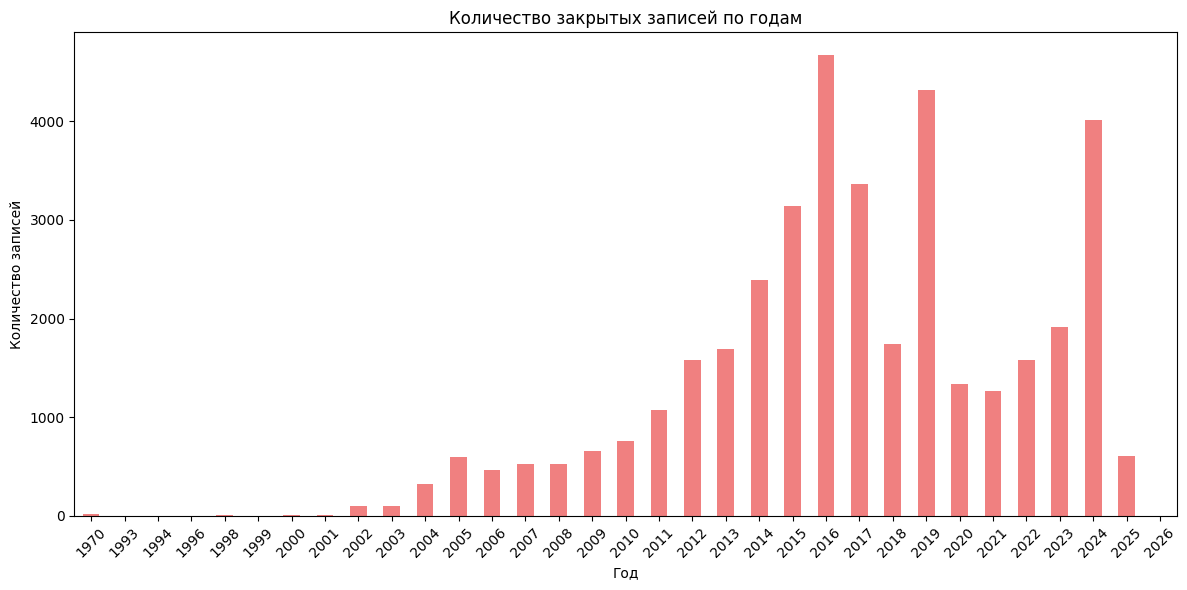

  📈 График сохранен: inn_analysis_results\закрытые_записи_по_годам.png

💾 Сохранение анализа закрытых записей...
  📊 Анализ закрытых записей сохранен в: inn_analysis_results\анализ_закрытых_записей.xlsx
Исключено записей с датой закрытия: 38755
Осталось записей для анализа дубликатов: 634706

2. БАЗОВАЯ СТАТИСТИКА ПО ИНН
----------------------------------------
Общее количество записей: 634706
Записей с указанным ИНН: 532647 (83.9%)
Записей без ИНН: 102059 (16.1%)

3. АНАЛИЗ ФОРМАТА ИНН
----------------------------------------
Распределение по типам ИНН:
  Юридическое лицо (10 цифр): 442374 (83.1%)
  Физическое лицо/ИП (12 цифр): 90272 (16.9%)
  Некорректная длина (11 цифр): 1 (0.0%)

4. ДЕТАЛЬНЫЙ АНАЛИЗ ДУБЛИКАТОВ ИНН
----------------------------------------
Уникальных ИНН с дубликатами: 6505
Всего записей с дублирующимися ИНН: 30379

Топ-10 самых частых дубликатов ИНН:
  1. ИНН 7707083893: 2209 повторений
  2. ИНН 7701285928: 898 повторений
  3. ИНН 2309051942: 800 повторений
  4. ИН

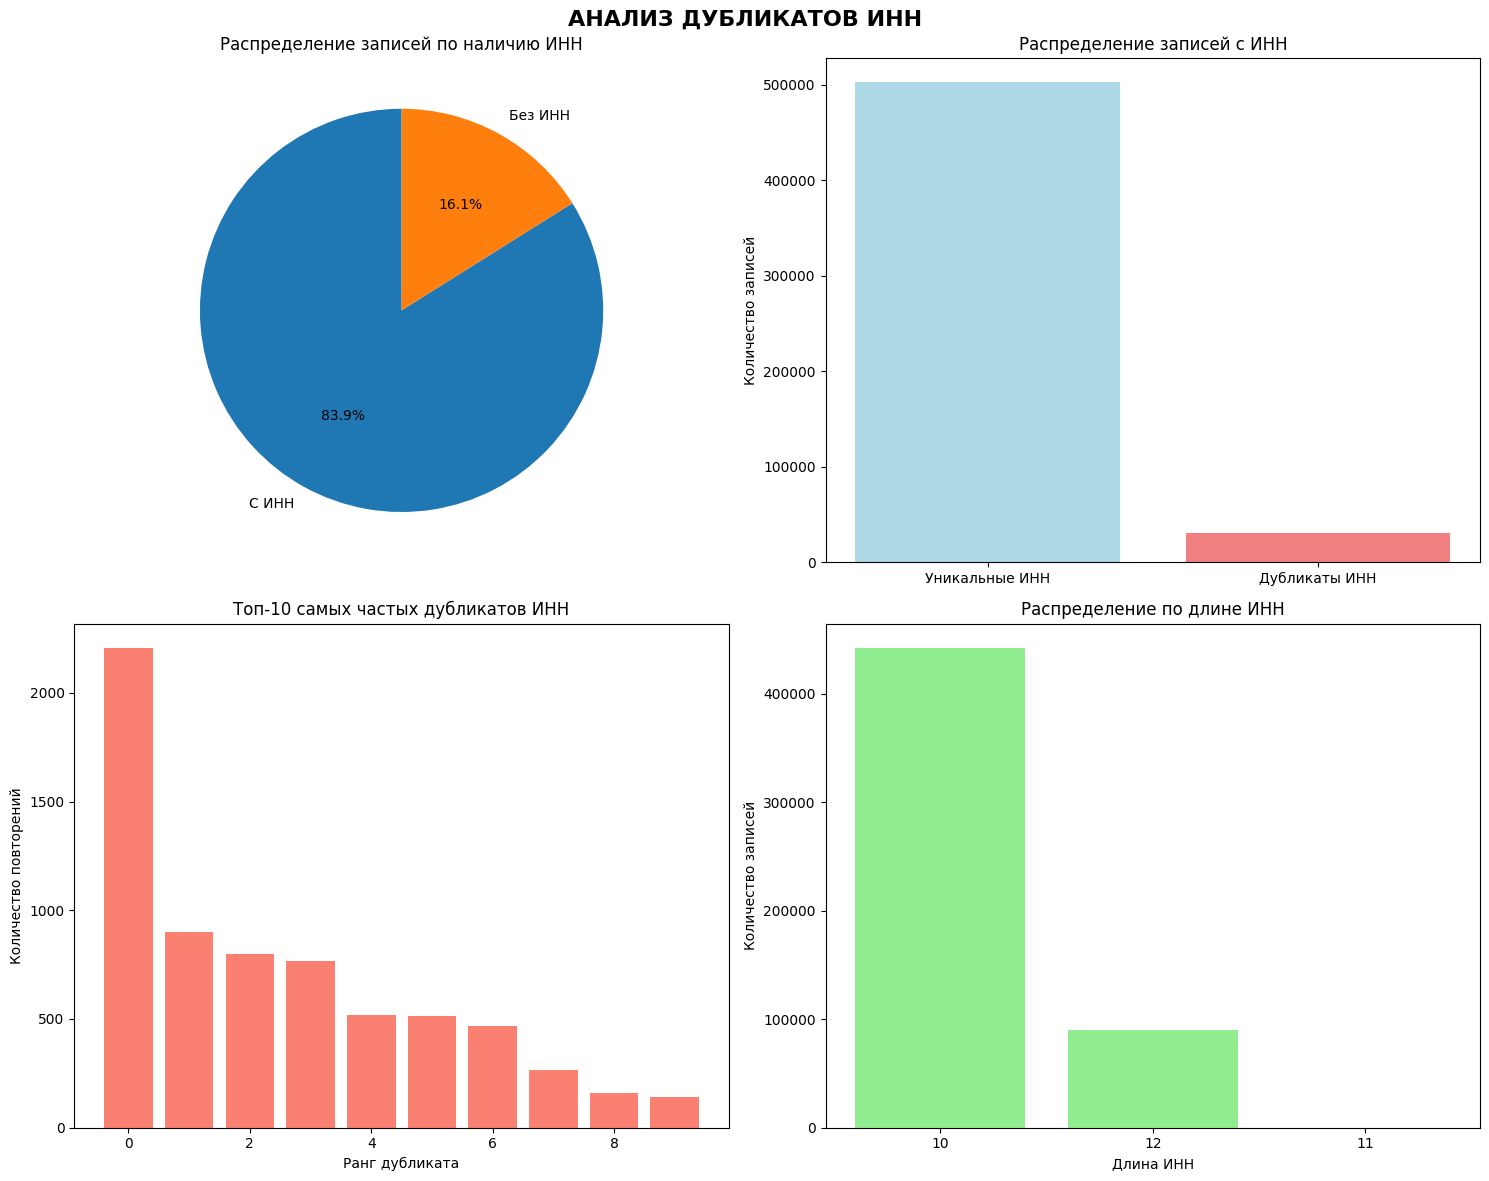

  📈 Визуализация сохранена в: inn_analysis_results\визуализация_анализа_ИНН.png

7. ИТОГОВАЯ СТАТИСТИКА
----------------------------------------
                                       Метрика  Значение
Всего записей (без заблокированных и закрытых)    634706
                        Записей с валидным ИНН    532647
                               Записей без ИНН    102059
                                Уникальных ИНН    508773
                             ИНН с дубликатами      6505
               Всего записей с дубликатами ИНН     30379
 Самый частый дубликат (количество повторений)      2209
  📊 Итоговая статистика сохранена в: inn_analysis_results\итоговая_статистика.xlsx

📁 Результаты сохранены в папку: inn_analysis_results


In [32]:

analyze_inn_duplicates(df)
